<u>**IMPORTANT NOTE**</u>

>Please proceed with this example **iff** you are familier with foundation of Microsoft Azure public cloud. In this notebook, the basics of Microsoft Azure and its development methodology is not covered. As it will be beyond the scope of this notebook.

* [PART 1: Azure Machine Learning service - Introduction](https://www.kaggle.com/pankaj1234/azure-machine-learning-introduction): in the first notebook I have already discussed about the nitty-gritty of Azure ML service.
    * Creating an instance of Azure ML service
    * Downloading libraries/dependencies (in Kaggle environment)
    * Various methods to connect to Azure ML service workspace: using config file and using get() method.
    * Simple ML experiment - for data exploration. Capture the details from the experiment, logging and preserving the run details from the experiment.
    * Overview of Azure ML Service Dashboard. Experiment Dashboard.
    
* [PART 2: Azure Machine Learning service - Introduction II](https://www.kaggle.com/pankaj1234/azure-machine-learning-introduction-ii): I did deep-dive into the introduction and covered some more topics:
    * Create and run the experiment using <u>Custom Script</u> file. Implementing simple Logistic Regression model on IRIS dataset.
    * RunConfiguration and ScriptRunConfiguration, these classes were used to define the runtime environment for the custom script.
    * Output the model and run details to the external folder for future referencing.
    
# Azure Machine Learning Service - III
In this third part from the same Azure Machine Learning Service (**AML**) series I will do a experiment to show:
* How to pass parameters to the <u>Custom Script</u> so that it can run experiment dynamically.
* Advantage of using Estimator API over RunConfiguration and ScriptRunConfiguration
* Register and Consuming the Machine Learning Model in AML service.


In [ ]:
# import the Azure ML libs.
!pip install azureml
!pip install azureml.core
!pip install azureml.widgets
!pip install azureml.train

import azureml.core
import azureml.widgets 
print("Ready to use Azure ML", azureml.core.VERSION)
from azureml.core import Workspace

In [ ]:
## in this segment you should replace the 3-parameters values according to the workspace available in the subscription
## ths experiment will not work beyond this point if these values are not appropriatly inserted.
## HENCE, THE Notebook Execution will terminate

## Example - 
    ## ws = Workspace.get(name="<<MLSERVICENAME>>", subscription_id='<<GUID - ML Service ID>>', resource_group='<<Hosting Azure Resource Group>>')

# Pulling values from Kaggle Secrets
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
MLServiceName = user_secrets.get_secret("MLServiceName")
az_resource_grp = user_secrets.get_secret("az_resource_grp")
sub_id = user_secrets.get_secret("sub_id")

## Instanciating the Workspace object.
ws = Workspace.get(name=MLServiceName, subscription_id=sub_id, resource_group=az_resource_grp)
print(ws.name, "loaded")

> Code segment below will create the experiment folder and also copy the data for the experimnt to run from.

In [ ]:
import os, shutil

# Create a folder for the experiment files
folder_name = 'experiment-files'
experiment_folder = './' + folder_name
os.makedirs(experiment_folder, exist_ok=True)

#Copy the datast in the experiment folder so that it is made locally available to the model when it runs frm the script
shutil.copy('../input/iris-flower-dataset/IRIS.csv', os.path.join(folder_name, "IRIS.csv"))

## Passing Script Parameters
Before I discuss about the Estimator API of AML. I will be defining the script wich will accept the input parameters while it is called from the Estimator API for training and implementing the model. Passing a parameter value uning **argparse** allow us to run this experiment using different settings.The parameter which is defined here is regularization rate for the Logistic Regression model

In [ ]:
%%writefile $folder_name/iris_simple_experiment.py
from azureml.core import Run
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import joblib
import os

#"argparse" to define the input parameters for the script.
import argparse

# Get the experiment run context -  we are going to pass this configuration later
run = Run.get_context()

#define the regularization parameter for the logistic regression. I will pass this value from Estimator API of the Experiment later.
parser = argparse.ArgumentParser()
parser.add_argument('--reg_rate', type=float, dest='reg', default=0.01)
args=parser.parse_args()
r = args.reg

# load the data from a local file
data = pd.read_csv('IRIS.csv')
X = data[['sepal_length', 'sepal_width','petal_length','petal_width']].values
X=StandardScaler().fit_transform(X)
Y= (data['species']).map(lambda x: 0 if x=='Iris-setosa' else (1 if x=='Iris-versicolor' else 2))

#Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25, random_state=1234)
# fit the model
run.log("model regularization", np.float(r))
model = LogisticRegression(C=1/r, solver='lbfgs', multi_class='multinomial').fit(X_train,Y_train)

Y_pred = model.predict(X_test)
accuracy = np.average(Y_test == Y_pred)
print("accuracy: " + str(accuracy))
run.log("Accuracy", np.float(accuracy))

# Save the trained model in the "outputs" folder. The "outputs" folder is standard output folder for AML.
os.makedirs("outputs", exist_ok=True)
joblib.dump(value=model, filename='outputs/iris_simple_model.pkl')
# Complete the run
run.complete()

## Estimator API
Once I was able to define the experment script with all the required parameter details, the next code segment below is for Estimator implementation. The Estimator is used to encapsulate both previously learnt RunConfiguration and ScriptRunConfiguration in 1 step. Hence it is an abstraction on these 2 combined.<br/>
The code segment below uses the generic **Estimator** object to run the training Experiment. It has a power to provision any compute resource for experiment execution, e.g. Container, VM, or local compute, using **compute_target** parameter. <br/>
The generic Estimator does not include the scikit-learn packages therefore I have to pass the value for **conda_packages** parameter. One can also use estimator objects as **framework_specific** SKLearn or Tensorflow or PyTorch to avoid using explicit Conda_packages as parameter.

- See the comment section for SKLearn as an Estimator.
- See the parameters passed which are already defined in above script. '--reg_rate'


In [ ]:
from azureml.train.estimator import Estimator
from azureml.core import Experiment
from azureml.widgets import RunDetails

# Create an estimator
estimator = Estimator(source_directory=experiment_folder,
                      entry_script='iris_simple_experiment.py',
                      compute_target='local',
                      use_docker=False,
                      script_params = {'--reg_rate': 0.07},
                      conda_packages=['scikit-learn']
                      )

# COMMENTED - SKLearn as an estimator
#estimator = SKLearn(source_directory=experiment_folder, entry_script='iris_simple_experiment.py', compute_target='local', use_docker=False)

# Create an experiment
experiment_name = 'iris-estimator-experiment'
experiment = Experiment(workspace = ws, name = experiment_name)

# Run the experiment based on the estimator
run = experiment.submit(config=estimator)

# Get Run Details
RunDetails(run).show()

# Wait to complete the experiment. In the Azure Portal we will find the experiment state as preparing --> finished.
run.wait_for_completion(show_output=True)

> Get Experiment details, logs, files and captured metrics.

In [ ]:
# get logged Metrics.
metrics = run.get_metrics()
print("Metrics")
for key in metrics.keys():
    print(key, metrics.get(key))
print("\nFile Names")
for file in run.get_file_names():
    print(file)

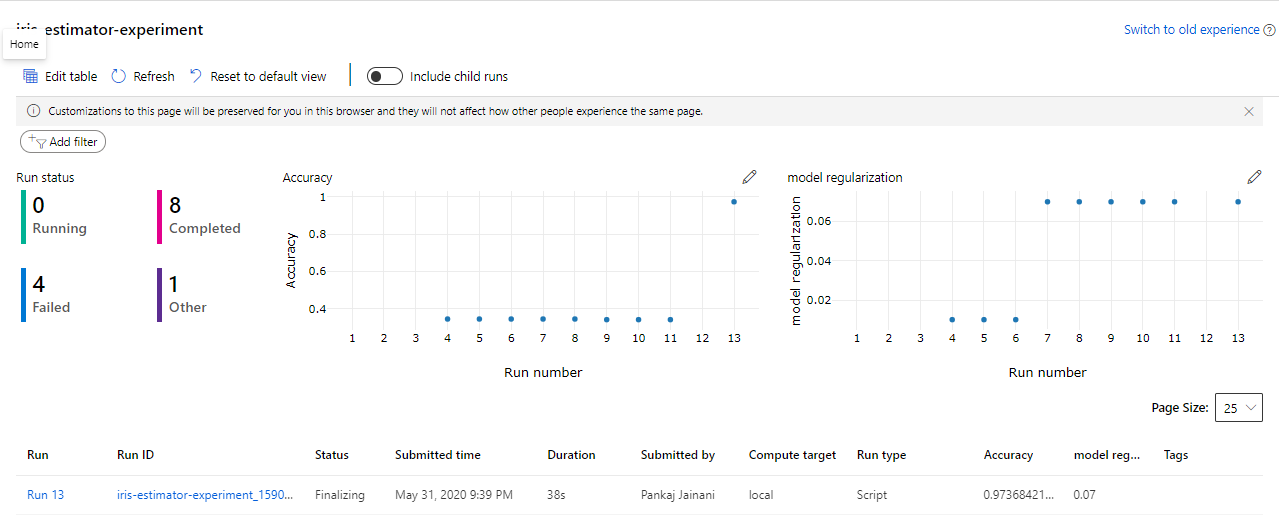

**See the --reg_rate (Model Regularization) parameter with its assigned value.**

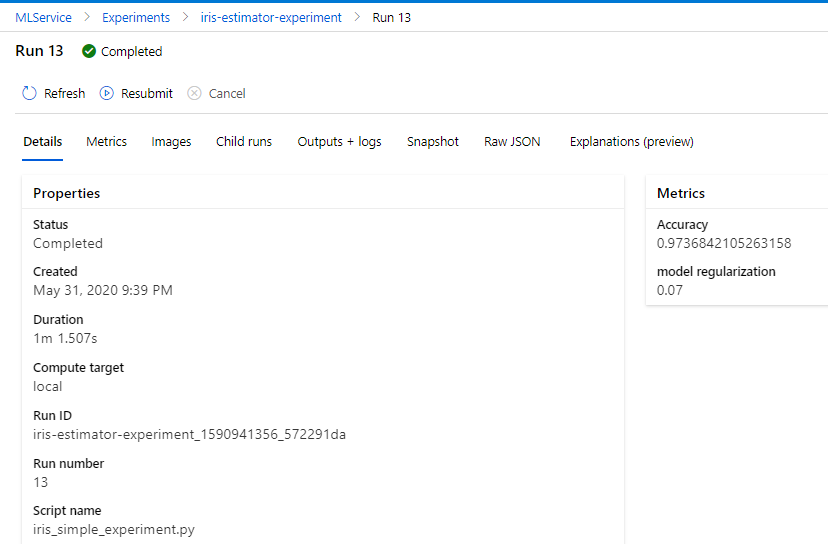

**Expriment Output  - Model (.pkl) & logs**

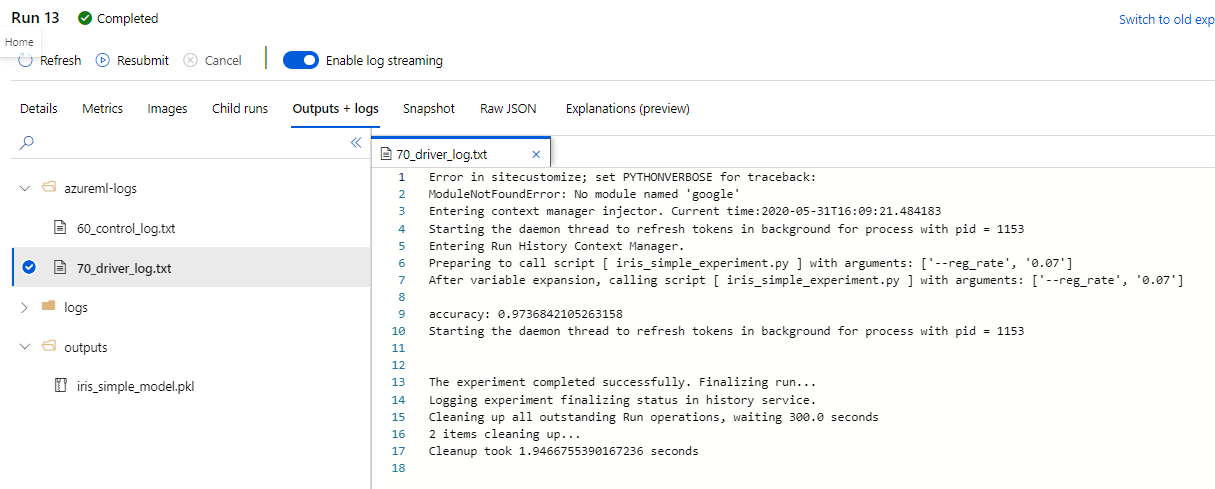

## Register Model
Once the model is trained and captured as \*.pkl with the experiment run it can be registered with Name and Version number. Also, there are few meta-data proprties and tags can also be updated with the registered model.

In [ ]:
from azureml.core import Model

run.register_model(model_path='outputs/iris_simple_model.pkl', model_name='iris_estimator_model', tags={"Training Context":"Estimator", "Script Context":"Parameters"},
                  properties={"Accuracy":run.get_metrics()["Accuracy"]})

In [ ]:
for model in Model.list(ws):
    print(model.name, ":", model.version)
    print("\nTag List")
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print(tag_name, tag)
    print("\nProperties List")
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print(prop_name,prop)

Models with version numbers as registered in Azure Portal in AML workspace.
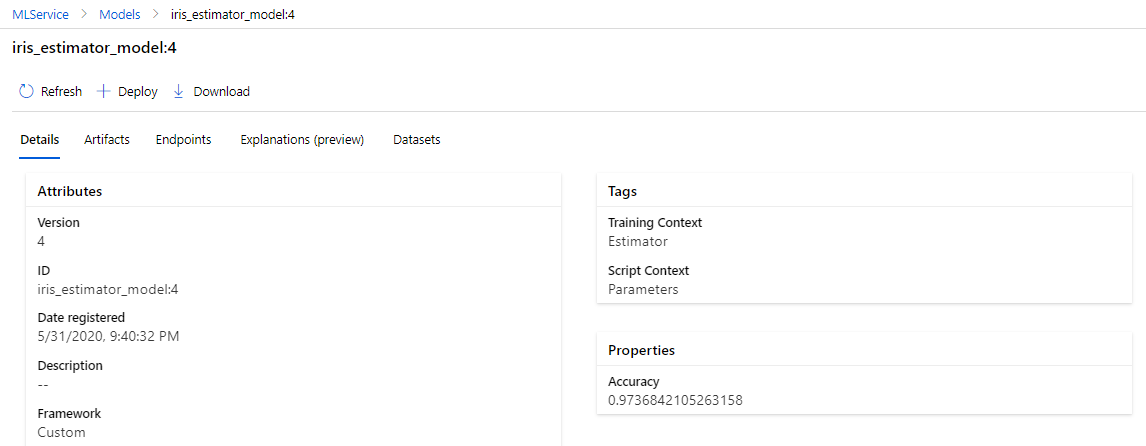

## What Next?
In the next notebook I will discuss about:
- How to enable different data sources to enable cloud machine learning. Example - blob storage and tables.
- Pass the data_set using the Estimator object. This will help to avoid passing static data_set files with the experiment (e.g. Iris csv) and enable online learning wile constantly looking into the remote data sources defined within the experiment.

Phew - if you are feeling too much overwhelmed with these concepts.. wait for my next notebook to uncover these. :) 